In [68]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [69]:
df = pd.read_excel(r"C:\Users\Martin\Desktop\Python na kaggle\Online Retail.xlsx")

In [70]:
print(df.head())
print(df.info())


  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       -----------

In [71]:
print(df.isna().sum())

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In [72]:
df.dropna(inplace = True)

In [73]:
print(df.isna().sum())

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64


In [74]:
neplatne_hodnoty_q = df['Quantity'] <= 0
neplatne_hodnoty_p = df['UnitPrice'] <= 0
print(neplatne_hodnoty_q.sum())
print(neplatne_hodnoty_p.sum())

8905
40


In [75]:
df = df[(df['Quantity'] > 0) & (df['UnitPrice']> 0)]

In [76]:
neplatne_hodnoty_q2 = df['Quantity'] <= 0
neplatne_hodnoty_p2 = df['Quantity'] <= 0
print(neplatne_hodnoty_q2.sum())
print(neplatne_hodnoty_p2.sum())


0
0


In [77]:
print(df.duplicated().sum())





5192


In [78]:

df.drop_duplicates(inplace = True)

In [79]:
print(df.duplicated().sum())


0


In [80]:
# Přidání sloupce total 
df['Amount'] = df['Quantity'] * df['UnitPrice']

In [81]:
from scipy import stats 


# Definujte referenční datum a ujistěte se, že je ve formátu datetime
reference_date = pd.to_datetime(df['InvoiceDate'].max()) + pd.Timedelta(days=1)

# Získání posledního nákupu pro každého zákazníka
rfm = df.groupby('CustomerID').agg(
    LastPurchaseDate=('InvoiceDate', 'max'),  # Poslední nákup
    FirstPurchaseDate=('InvoiceDate', 'min')  # První nákup
).reset_index()

# Výpočet recency (počet dnů od posledního nákupu)
rfm['Recency'] = (reference_date - rfm['LastPurchaseDate']).dt.days

number_transaciton = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()

number_transaciton.columns = ['CustomerID','Frequency']

rfm2= rfm.merge(number_transaciton, on = 'CustomerID')

amount_sum = df.groupby('CustomerID')['Amount'].sum().reset_index()

amount_sum.columns = ['CustomerID', 'Monetary']

rfm_analysis = rfm2.merge(amount_sum, on = 'CustomerID')

rfm_analysis['Z_Recency'] = stats.zscore(rfm_analysis['Recency'])
rfm_analysis['Z_Frequency'] = stats.zscore(rfm_analysis['Frequency'])
rfm_analysis['Z_Monetary'] = stats.zscore(rfm_analysis['Monetary'])

# Opravená funkce pro klasifikaci Z-skóre
def categorize_z_score(value, is_recency=False):
    if is_recency:
        if value >= 1:
            return 1  # Nízké skóre (vyšší recency)
        elif value >= 0:
            return 2
        elif value >= -1:
            return 3
        else:
            return 4  # Vysoké skóre (nižší recency)
    else:
        if value >= 1:
            return 4  # Vysoké skóre
        elif value >= 0:
            return 3
        elif value >= -1:
            return 2
        else:
            return 1  # Nízké skóre

# Přiřazení RFM skóre
rfm_analysis['R'] = rfm_analysis['Z_Recency'].apply(categorize_z_score, is_recency=True)
rfm_analysis['F'] = rfm_analysis['Z_Frequency'].apply(categorize_z_score)
rfm_analysis['M'] = rfm_analysis['Z_Monetary'].apply(categorize_z_score)

# Celkové skóre 
rfm_analysis['RFMScore'] = rfm_analysis['R'] + rfm_analysis['F'] + rfm_analysis['M']

# Výpis výsledného DataFrame
print(rfm_analysis[['CustomerID', 'Recency', 'Frequency', 'Monetary', 'RFMScore']])



      CustomerID  Recency  Frequency  Monetary  RFMScore
0        12346.0      326          1  77183.60         7
1        12347.0        2          7   4310.00         9
2        12348.0       75          4   1797.24         7
3        12349.0       19          1   1757.55         7
4        12350.0      310          1    334.40         5
...          ...      ...        ...       ...       ...
4333     18280.0      278          1    180.60         5
4334     18281.0      181          1     80.82         6
4335     18282.0        8          2    178.05         7
4336     18283.0        4         16   2045.53         9
4337     18287.0       43          3   1837.28         7

[4338 rows x 5 columns]


In [82]:
mean_RFMScore = rfm_analysis['RFMScore'].mean()

def creating_segments(rfm_score):
    if rfm_score >= mean_RFMScore + 2:  # Práh pro 'Champions'
        return 'Champions'
    elif rfm_score >= mean_RFMScore + 1:  # Práh pro 'Loyal Customers'
        return 'Loyal Customers'
    elif rfm_score >= mean_RFMScore:  # Práh pro 'Potential Loyalists'
        return 'Potential Loyalists'
    elif rfm_score >= mean_RFMScore - 1:  # Práh pro 'At Risk'
        return 'At Risk'
    else:
        return 'Low Value'

# Aplikace funkce pro vytvoření segmentu
rfm_analysis['RFM_Segment'] = rfm_analysis['RFMScore'].apply(creating_segments)
print(rfm_analysis)

      CustomerID    LastPurchaseDate   FirstPurchaseDate  Recency  Frequency  \
0        12346.0 2011-01-18 10:01:00 2011-01-18 10:01:00      326          1   
1        12347.0 2011-12-07 15:52:00 2010-12-07 14:57:00        2          7   
2        12348.0 2011-09-25 13:13:00 2010-12-16 19:09:00       75          4   
3        12349.0 2011-11-21 09:51:00 2011-11-21 09:51:00       19          1   
4        12350.0 2011-02-02 16:01:00 2011-02-02 16:01:00      310          1   
...          ...                 ...                 ...      ...        ...   
4333     18280.0 2011-03-07 09:52:00 2011-03-07 09:52:00      278          1   
4334     18281.0 2011-06-12 10:53:00 2011-06-12 10:53:00      181          1   
4335     18282.0 2011-12-02 11:43:00 2011-08-05 13:35:00        8          2   
4336     18283.0 2011-12-06 12:02:00 2011-01-06 14:14:00        4         16   
4337     18287.0 2011-10-28 09:29:00 2011-05-22 10:39:00       43          3   

      Monetary  Z_Recency  Z_Frequency 

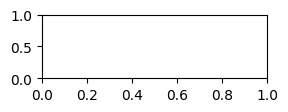

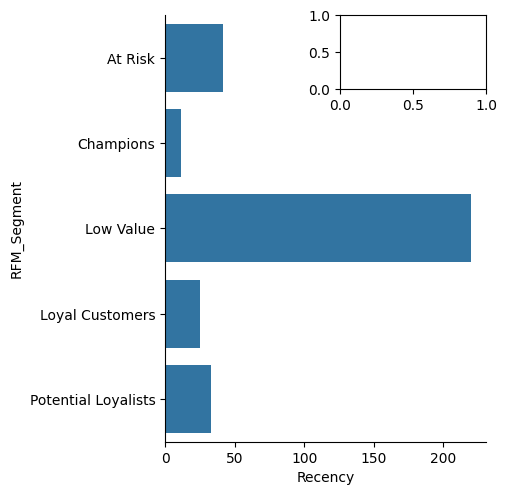

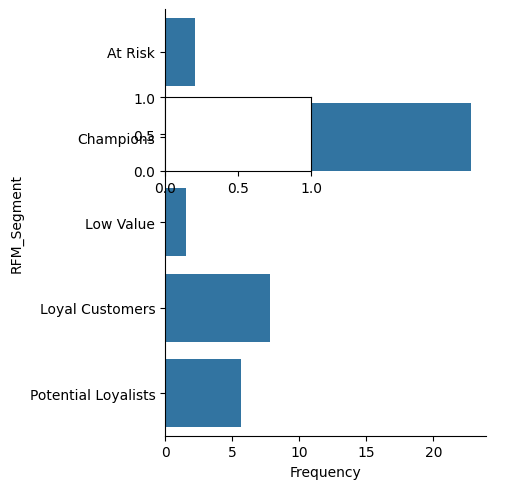

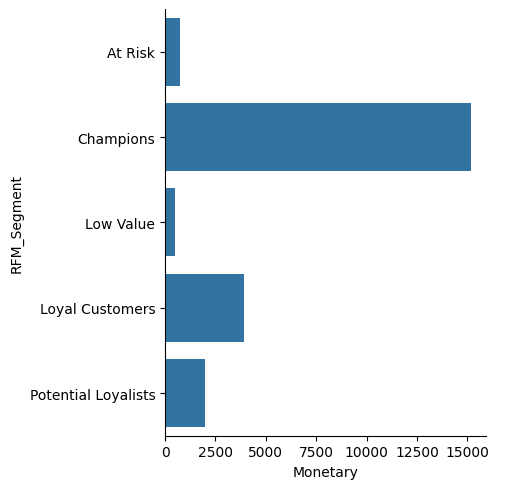

In [83]:
import matplotlib.pyplot as plt


rfm_agg = rfm_analysis.groupby('RFM_Segment').agg({
    'Recency': 'mean',       # Např. průměrná, minimální a maximální hodnota Recency pro každý segment
    'Frequency': 'mean',                      # Průměrná hodnota Frequency
    'Monetary': 'mean'             # Součet a průměr pro Monetary v rámci každého segmentu
}).reset_index()

plt.subplot(5,2,1)
# Průměrná doba od posledního nákupu 
sns.catplot(data = rfm_agg, y = 'RFM_Segment', x = 'Recency', kind = 'bar')
plt.subplot(5,2,2)
# Průměrná frekvence nákupů
sns.catplot(data = rfm_agg, y = 'RFM_Segment', x = 'Frequency', kind = 'bar')
plt.subplot(5,2,3)
#Průměrná hodnota nákupů (Monetary Value)
sns.catplot(data = rfm_agg, y = 'RFM_Segment', x = 'Monetary', kind = 'bar')


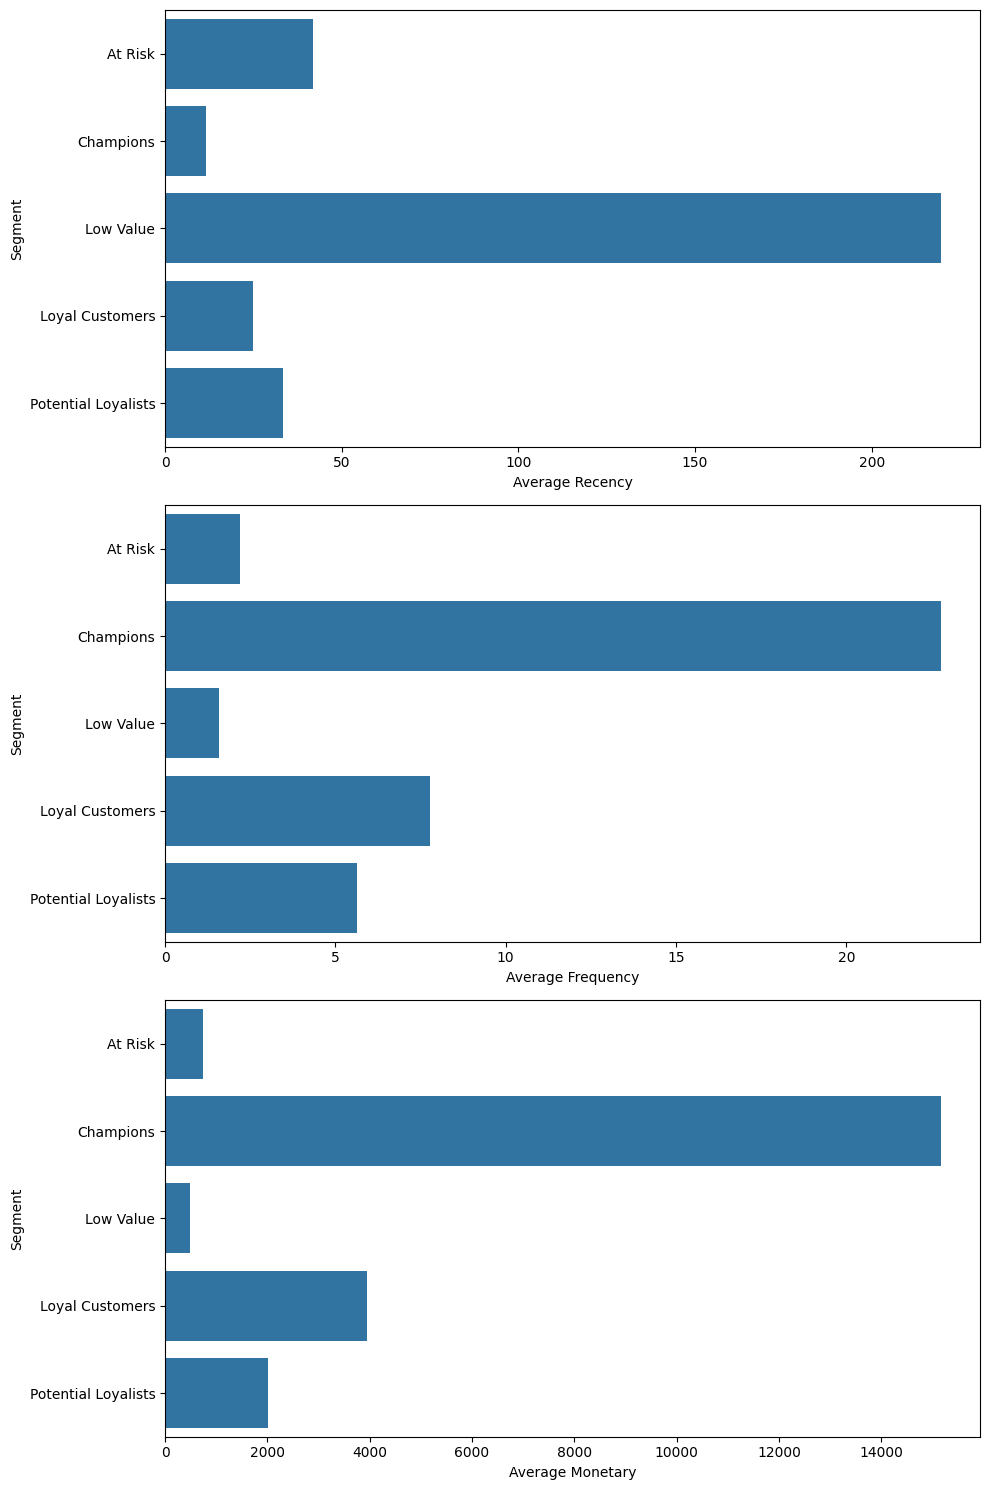

In [106]:
import matplotlib.pyplot as plt


rfm_agg = rfm_analysis.groupby('RFM_Segment').agg({
    'Recency': 'mean',       # Např. průměrná, minimální a maximální hodnota Recency pro každý segment
    'Frequency': 'mean',                      # Průměrná hodnota Frequency
    'Monetary': 'mean'             # Součet a průměr pro Monetary v rámci každého segmentu
}).reset_index()

fig, ax = plt.subplots(3, 1, figsize=(10, 15))  # 3 řádky, 1 sloupec

# Vykreslení grafů na jednotlivé osy pomocí sns.barplot a nastavení popisků
sns.barplot(data=rfm_agg, y='RFM_Segment', x='Recency', ax=ax[0])
ax[0].set_ylabel("Segment")
ax[0].set_xlabel("Average Recency")

sns.barplot(data=rfm_agg, y='RFM_Segment', x='Frequency', ax=ax[1])
ax[1].set_ylabel("Segment")
ax[1].set_xlabel("Average Frequency")

sns.barplot(data=rfm_agg, y='RFM_Segment', x='Monetary', ax=ax[2])
ax[2].set_ylabel("Segment")
ax[2].set_xlabel("Average Monetary")

plt.tight_layout()
plt.show()



In [84]:
#zákazníci s více než jedním nákupem
multiple_purchases = rfm_analysis[rfm_analysis['Frequency'] > 1].groupby('RFM_Segment')['CustomerID'].nunique().reset_index()

multiple_purchases.columns = ['RFM_Segment', 'Multiple_Purchases']

single_purchases = rfm_analysis[rfm_analysis['Frequency'] == 1].groupby('RFM_Segment')['CustomerID'].nunique().reset_index()

single_purchases.columns = ['RFM_Segment', 'Single_Purchases']

total_customers = rfm_analysis.groupby('RFM_Segment')['CustomerID'].nunique().reset_index()
total_unique = rfm_analysis['CustomerID'].nunique()
total_customers.columns = ['RFM_Segment', 'Total_Customers']

summary_df = total_customers.merge(multiple_purchases, on='RFM_Segment', how='left')
summary_df = summary_df.merge(single_purchases, on='RFM_Segment', how='left')
summary_df['Single_Purchases'] = summary_df['Single_Purchases'].fillna(0).astype(int)
summary_df['Multiple_Purchase_Rate'] = (summary_df['Multiple_Purchases'] / total_unique)*100
summary_df['Single_Purchase_Rate'] = (summary_df['Single_Purchases'] / total_unique)*100




In [85]:
df_merged = df.merge(rfm_analysis, on = 'CustomerID')



In [86]:
df_merged = df.merge(rfm_analysis, on = 'CustomerID')



Text(0.5, 1.0, 'Total amount by segment')

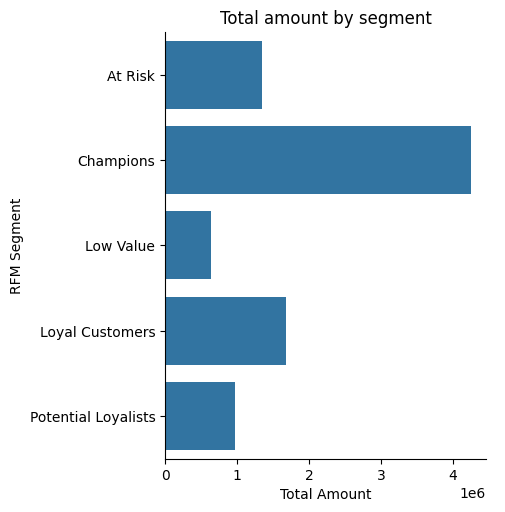

In [95]:
sales_by_segment = df_merged.groupby('RFM_Segment')['Amount'].sum().reset_index()
sns.catplot(data = sales_by_segment, x = 'Amount', y = 'RFM_Segment', kind = 'bar')
plt.ylabel("RFM Segment")
plt.xlabel("Total Amount")
plt.title("Total amount by segment")

Text(0.5, 1.0, 'Averege order value by segment')

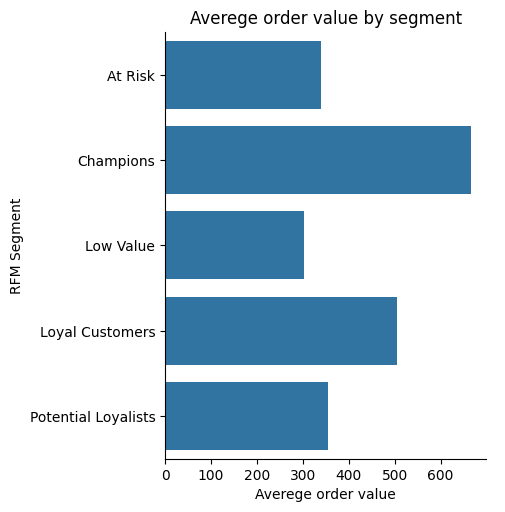

In [96]:
def average_order_value(segment):
    amount_total = segment['Amount'].sum()        # Celková částka pro daný segment
    orders_total = segment['InvoiceNo'].nunique() # Počet unikátních objednávek pro daný segment
    average_value = amount_total / orders_total   # Výpočet průměrné hodnoty objednávky
    return round(average_value, 2)                # Zaokrouhlení na dvě desetinná místa

# Aplikace funkce na každý RFM segment
aov = df_merged.groupby('RFM_Segment')[['Amount', 'InvoiceNo']].apply(average_order_value).reset_index(name='AOV')
sns.catplot(data = aov, x = 'AOV', y = 'RFM_Segment', kind = 'bar')
plt.xlabel("Averege order value")
plt.ylabel("RFM Segment")
plt.title("Averege order value by segment")
